In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from wordcloud import WordCloud

# read data
df = pd.read_csv('archive/AB_NYC_2019.csv')

# consts
BOROUGH = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
ROOMMAP = {'Entire home/apt':2, 'Private room':1, 'Shared room':0}
IMG = plt.imread('archive/nyc.jpeg')
AREA = [-74.24442, -73.71299, 40.49979, 40.91306]
# df.iloc[np.r_[0:5, -5:0]]

In [2]:
"""
1. Examine the data, there may be some anomalies in the data, and you will have to clean the data
   before you move forward to other tasks. Explain what you did to clean the data. (10 Points)

After reviewing the features provided by the data, I've concluded that the only anomaly I can remove
is when the listing of the Airbnb has a price of zero. This is because Airbnb is a business, it only
makes sense if there is a price listed. I performed the cleaning by removing entries where price = 0.
This caused the number of entries to go from 48895 to 48884, 11 entries removed.

availability_365 is another feature that i considered could be useful in identifying anomalies.
However, after learning that availability means the number of days in the next year where this Airbnb
is available for rent, I believe that this feature would not find abnormal data. One might say that
an availability of 0 would be weird, but that could mean the Airbnb is being renovated, therefore can
not be offered.

number_of_reviews can not be considered to remove entries because the number of reviews is depended
on the people who rent the place. Even though there could be fake reviews, this dataset alone is not
sufficient to identify which ones are not legit. The same can be said about last_review and
reviews_per_month, they depend on the people who rent the Airbnbs.

minimum_nights does not suggest any listing to be outliers since they are actual requirements for
the Airbnb. calculated_host_listings_count is just data about the host, there is nothing to look for
that can tell the listing is an anomaly.
"""
print(f"dataset size before cleaning: {len(df)}")
df = df[df['price'] != 0] # remove listings where price = 0
print(f"dataset size after cleaning: {len(df)}")

dataset size before cleaning: 48895
dataset size after cleaning: 48884


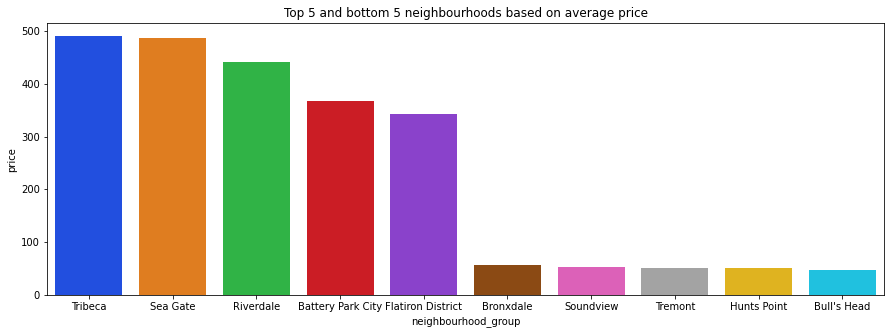

In [3]:
"""
2. Examine how the prices of the Airbnb changes with the change in the neighborhood.
a. Find Top 5 and Bottom 5 neighborhood based on the price of the Airbnb in that neighborhood
   (select only neighborhoods with more than 5 listings). (10 Points)

I first filtered out neighbourhoods with less than or equal to 5 listings. Then using groupby, I was
able to find the average price of each neighbourhood. To get the top 5 and bottom 5, I sorted the
price, then displayed the head and the tail of the dataframe.
"""
# filter out neighbourhoods with <= 5 listings, sort neighbourhoods by average of price
count = df['neighbourhood'].value_counts()
neighbourhood = df[df['neighbourhood'].isin(count[count > 5].index)].groupby('neighbourhood', as_index=False)[['neighbourhood', 'price']].mean('price').sort_values('price', ascending=False)

# display top 5 and bottom 5
# bar plot
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='neighbourhood', y='price', data=neighbourhood.iloc[np.r_[0:5, -5:0]], palette='bright', ax=ax)

# label
plt.title('Top 5 and bottom 5 neighbourhoods based on average price')
ax.set_xlabel('neighbourhood_group')
ax.set_ylabel('price')
plt.show()

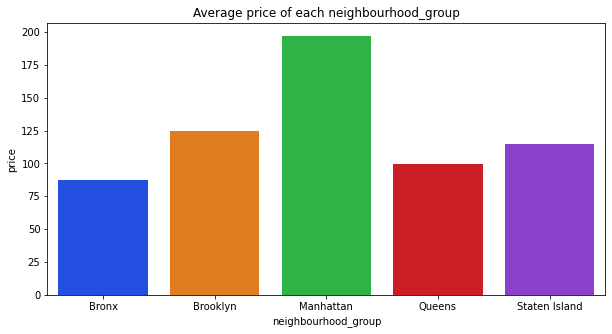

In [4]:
"""
b. Analyze, the price variation between different neighborhood group, and plot these trends. (5
   Points)

To show the trend of price variation between different neighbourhood_group, I worked with the mean prices
across the neighbourhood_group. I grouped them by neighbourhood_group so I can use the mean() function to
find the average price in each neighbourhood_group. To display the result, I used a bar plot, since it's
easy to see the difference each one has compared to the other ones. It appears that the average prices
sorted in descending order is as follows: Manhattan > Brooklyn > Staten Island > Queens > Bronx
"""
# find average of price in each neighbourhood_group
group = df[['neighbourhood_group', 'price']].groupby('neighbourhood_group', as_index=False).mean('price')

# # bar plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='neighbourhood_group', y='price', data=group, palette='bright', ax=ax)

# label
plt.title('Average price of each neighbourhood_group')
plt.show()

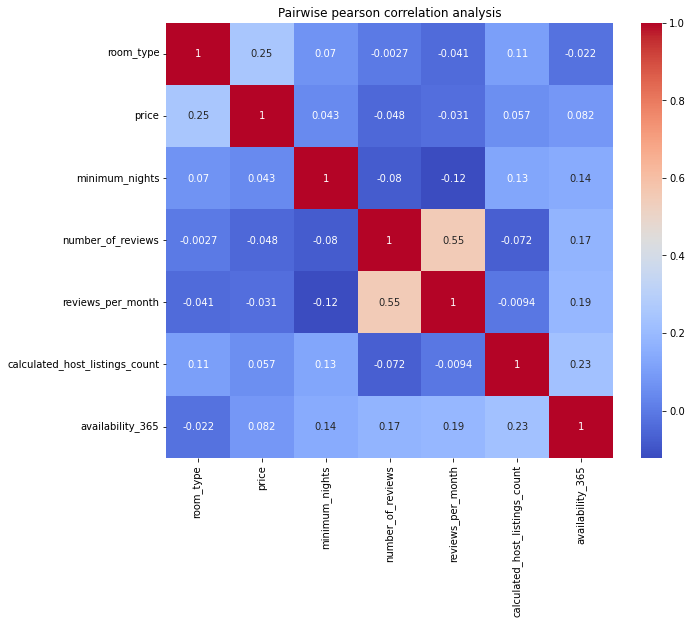

In [5]:
"""
3. Select a set of the most interesting features. Do a pairwise Pearson correlation analysis on all pairs
   of these variables. Show the result with a heat map and find out most positive and negative
   correlations. (5 points)

To perform a correlation analysis, I first have to exclude columns that are not numbers, or convert the
dtype of that column into numbers. The column I converted into numbers is room_type. I believe that
room_type would be correlated to price, so I converted it using the following metric:
{'Entire home/apt':2, 'Private room':1, 'Shared room':0}
This ordering can be justified by the fact that 'Entire home/apt' is more valuable than 'Private room'
and 'Private room' is more valuable than 'Shared room'. The heatmap shows that there is indeed a slight
correlation between room_type and price.

To further process the data, I've excluded columns that are irrelevant. These include id, host_id,
latitude, and longitude. Using the corr() function and plotting the correlation with a heatmap, I found
that there isn't any strong correlation (both positive and negative). The only exception is
number_of_reviews and reviews_per_month, but these two features explain a common feature, how often
customers review the Airbnb, so this correlation is not that interesting.
"""
# pairwise pearson correlation analysis
room = df['room_type'].map(ROOMMAP) # map room_type to numbers
num = df[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] # relevant features
corr = pd.concat([room, num], axis=1).corr() # correlation between features

# heatmap
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Pairwise pearson correlation analysis')
plt.show()

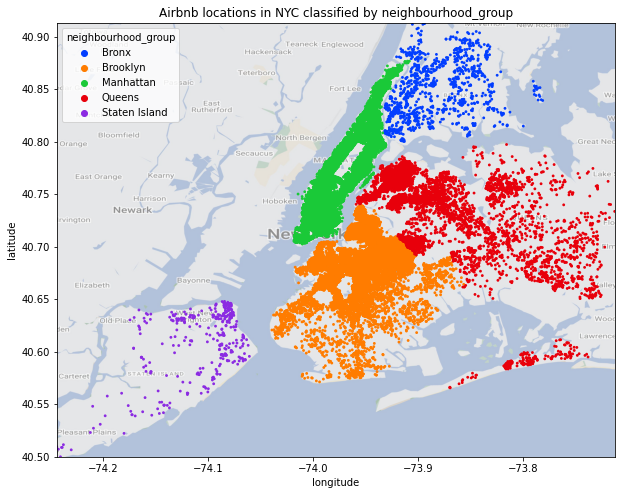

In [6]:
"""
4. The Latitude and Longitude of all the Airbnb listings are provided in the dataset.
a. Plot a scatter plot based on these coordinates, where the points represent the location of an
   Airbnb, and the points are color coded based on the neighborhood group feature. (5 Points)

To make this scatter plot, I plotted the longitude along the x-axis and the latitude along the y-axis.
I didn't think it gave a good visualization at first, especially for areas with not as dense airbnbs.
To improve the scatter plot, I put a background image of an actual map of NYC that I cropped along the
lowest and highest longitude and latitude. The custom map that I made can be found at:
https://www.google.com/maps/d/edit?mid=1Q38fON_TIBxXdmBHlZHGmNqB0D8qCWg5&usp=sharing
"""
coord = df[['neighbourhood_group', 'latitude', 'longitude']].sort_values('neighbourhood_group')

# plot coordinates
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(IMG, extent=AREA) # background map
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood_group', data=coord, palette='bright', s=8, linewidth=0, ax=ax)

# # label plot
plt.title('Airbnb locations in NYC classified by neighbourhood_group')
plt.show()

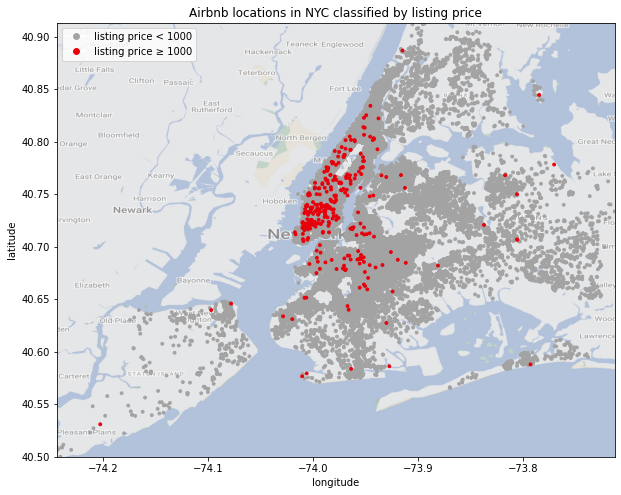

In [7]:
"""
b. Now again, plot a scatter plot based on these coordinates, where the points represent the
   location of an Airbnb, and the points are color coded based on the price of the particular Airbnb,
   where price of the listing is less than 1000. Looking at the graph can you tell which
   neighborhood group is the most expensive. (5 Points)

This plot follows almost the same procedures as the previous scatter plot, except that this time the
points are color coded by price. Since the point of this plot is to highlight listings where price is
more than or equal to 1000, I decided to use gray for prices less than 1000 and use red for the points
we want to see. This creates a contrast that allows for a more obvious visualization.

In addition, I found that graphing these points in the given order will actually cause many of the red
points to be obstructed by gray points. To fix this, I sorted the points by price in ascending order.
This makes it so that higher prices get plotted later than lower prices, so gray points will not cover
red points.

The resulting plot shows that Manhattan is the most expensive neighbourhood group. This also supports
the bar plot that was created in 2b.
"""
# sort by price so the points are more obvious on the plot
coord = df[['price', 'latitude', 'longitude']].sort_values(['price'], ascending=True)

# plot coordinates
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(IMG, extent=AREA)
ax.scatter(coord['longitude'], coord['latitude'], c=coord['price'].map(lambda x: sns.color_palette('bright')[7] if x < 1000 else sns.color_palette('bright')[3]), s=8)

# create legend
legend = [Line2D([0], [0], marker='o', color='w', label='listing price < 1000', markerfacecolor=sns.color_palette('bright')[7], markersize=8),
Line2D([0], [0], marker='o', color='w', label='listing price ≥ 1000', markerfacecolor=sns.color_palette('bright')[3], markersize=8)]
ax.legend(handles=legend, loc='upper left')

# label
plt.title('Airbnb locations in NYC classified by listing price')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

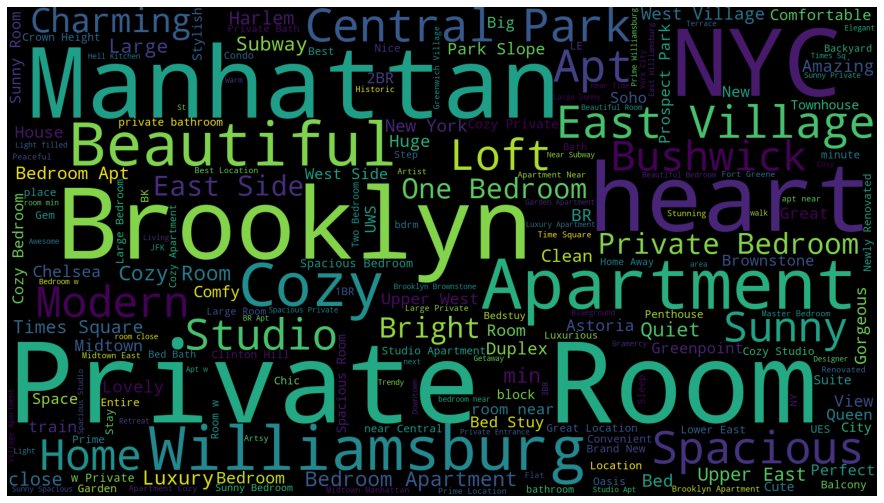

In [8]:
"""
5. Word clouds are useful tool to explore the text data. Extract the words from the name of the Airbnb
   and generate a word cloud. (5 Points)

Using the wordcloud library for python, I passed in a string that contains every name of the listing
in the dataframe. To do this, I first replace all the Nan with an empty string, then I joined all the
strings into one string. Finally, I adjusted the size so that the word cloud is more clear.
"""
# replace NaN with empty string
name = ' '.join(df['name'].fillna(''))

# create wordcloud
wordcloud = WordCloud(width=1600, height=900).generate(name)
plt.figure(figsize=(16, 9))
plt.axis("off")
plt.imshow(wordcloud)
plt.show()

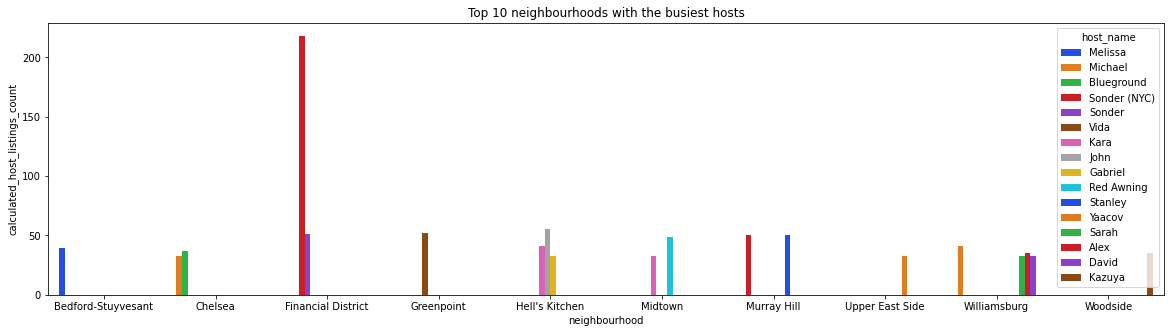

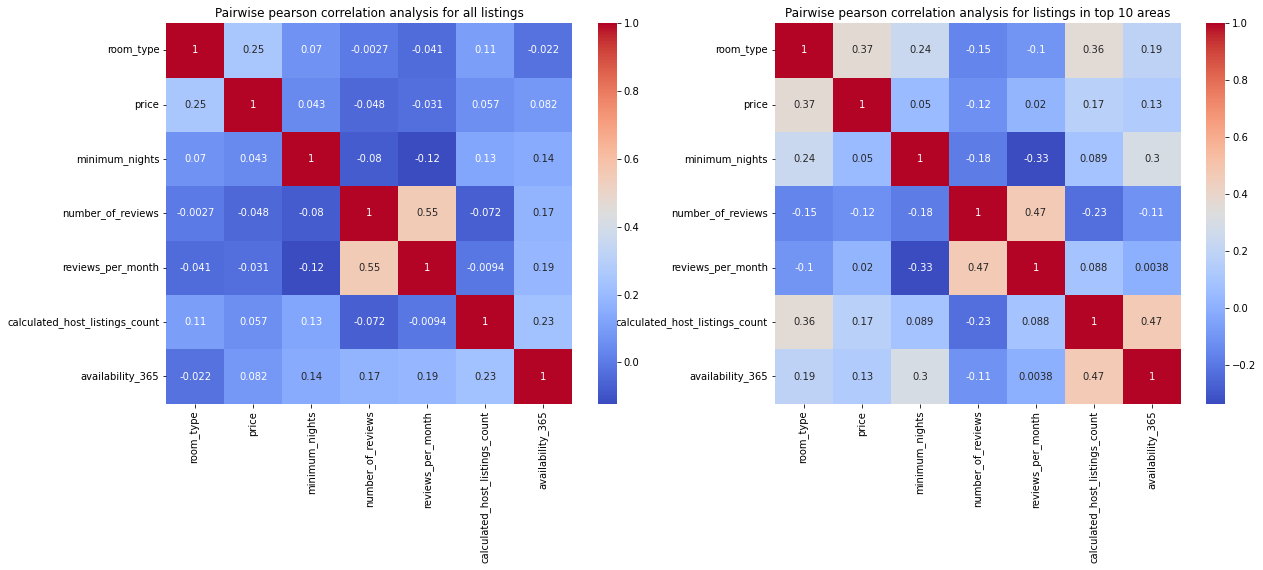

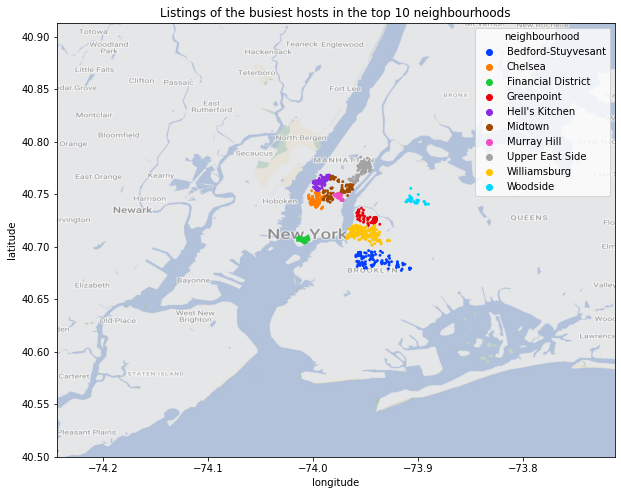

In [9]:
"""
6. Find out which areas has the busiest (hosts with high number of listings) host? Are there any
   reasons, why these hosts are the busiest, considers factors such as availability, price, review, etc.?
   Bolster you reasoning with different plots and correlations. (10 Points)

To see hwich areas has the hosts with high number of listings, I grouped by both neighbourhood and
host_name, then counted listings by neighbourhood, finally sorted by calculated_host_listings_count. This
will show me hosts with highest listing in neighbourhoods. The bar plot below presents the top 10 areas
with the busiest hosts.

To find the reasons why these hosts are the busiest, I used a pairwise pearson correlation analysis for
the top 10 hosts, and compare this heatmap with the heatmap I created in part 3. The major difference I
found is the correlation of calculated_host_listings_count and availability_365. This has the highest
correlaiton at 0.47. I think this is because hosts with the highest number of listings rent airbnbs as a
living, so it's natural that they make their airbnbs have high availability, so that they can get an
income. I don't there are other obvious trends to be found from the pairwise pearson correlation analysis.

In an attempt to find more explanation to why these areas have the busiest hosts, I plotted the listings
of the busiest hosts in the top 10 areas using a scatter plot. In the plot, it can be seen that 6/10 of
the areas are in Manhattan. 3/10 are in Brooklyn but fairly close to Manhattan. 1/10 is in Queens, also
fairly close to Manhattan. Manhattan is the business area of NYC, many people from across the world travel
there for business. This means that it is logical for hosts to have many airbnbs in or close to Manhattan
so that people will rent their place more often.

This has shown that data does not show everything. Sometimes you need other elements in order to explain a
phenomenon. I did not think the dataset itself was sufficient by itself to explain why those areas are the
ones with the busiest hosts until I plotted the locaitons on a map. Geography in this case was helpful to
explain the trend we are seeing about these airbnb hosts.
"""
# find areas with busiest hosts
listing = df[['neighbourhood', 'host_name', 'calculated_host_listings_count']].groupby(['neighbourhood', 'host_name'], as_index=False).count().sort_values('calculated_host_listings_count', ascending=False).head(19).sort_values('neighbourhood')

# bar plot
fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot(x='neighbourhood', y='calculated_host_listings_count', hue='host_name', data=listing, palette='bright')
plt.title('Top 10 neighbourhoods with the busiest hosts')
plt.show()



# analyze listings of the busiest hosts in top 10 areas
top10 = df[df['neighbourhood'].isin(listing['neighbourhood']) & df['host_name'].isin(listing['host_name'])].sort_values('neighbourhood')
room_top10 = top10['room_type'].map(ROOMMAP) # map room_type to numbers
num_top10 = top10[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] # relevant features
corr_top10 = pd.concat([room_top10, num_top10], axis=1).corr() # correlation between features

# display previous pairwise pearson correlation analysis
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Pairwise pearson correlation analysis for all listings')

# display pairwise pearson correlation analysis for top 10 areas
sns.heatmap(corr_top10, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Pairwise pearson correlation analysis for listings in top 10 areas')
plt.show()



# plot coordinates
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(IMG, extent=AREA) # background map
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood', data=top10, palette='bright', s=8, linewidth=0, ax=ax)
plt.title('Listings of the busiest hosts in the top 10 neighbourhoods')
plt.show()

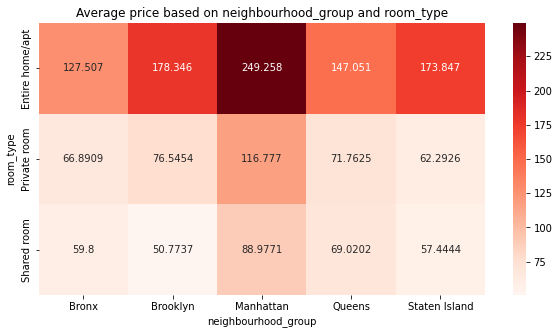

In [10]:
"""
7. Create two plots (at least one unique plot not used above) of your own using the dataset that you
   think reveals something very interesting. Explain what it is, and anything else you learned. (10
   Points)

Something interesting is the correlation of price and room_type in each neighbourhood_group. To show
this relationship, I used a heatmap so that it can be easily seen various combinaitons of room_type
and neighbourhood_group producing different average prices. Darker squares represent more expensive
prices and lighter squares represent cheaper prices.
"""
# Average price based on room_type and neighbourhood_group
price = df[['room_type', 'neighbourhood_group', 'price']].groupby(['room_type', 'neighbourhood_group'], as_index=False).mean()
matrix = np.reshape(np.array(price['price']), (3, 5)) # matrix of price to be passed to seaborn heatmap

# heatmap
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.heatmap(matrix, annot=True, fmt='g', cmap='Reds', xticklabels=BOROUGH, yticklabels=ROOMMAP.keys())

# label
plt.title('Average price based on neighbourhood_group and room_type')
ax.set_xlabel('neighbourhood_group')
ax.set_ylabel('room_type')
plt.show()

total listings: 48884
listings not displayed: 1044


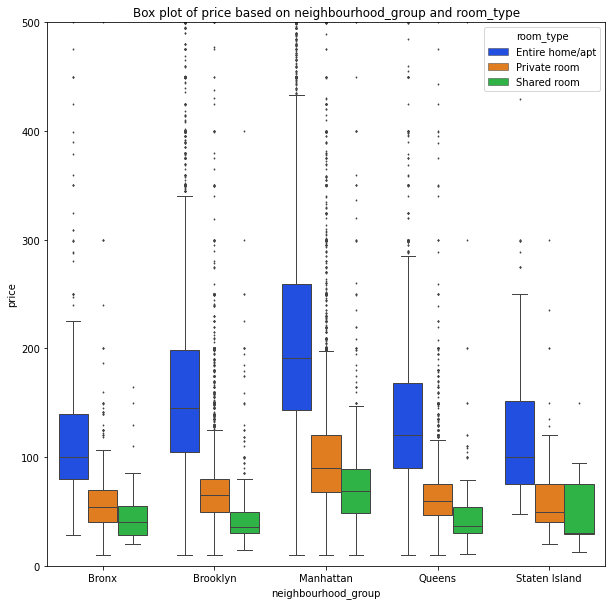

In [11]:
"""
7. ### unique plot not used above ###

To add on to the heatmap I created above, I decided to create a box plot that shows the realationship
between prices and the combinations of room_type and neighbourhood_group. The result agrees with the
heatmap naturally, since they came from the same dataset. Something interesting about this is that
quartiles are present, so we don't only focus on the mean, which does not say much.

To better display this plot, I set the range of the y-axis to display only from 0-500, because the graph
extends too high if I don't do this. I don't think this affected much the information that can be gained
here, as limiting the range to 0-500 only omitted about 2.136% of data points.
"""
# Average price based on room_type and neighbourhood_group
price = df[['room_type', 'neighbourhood_group', 'price']].sort_values(['neighbourhood_group', 'room_type'])
print('total listings: %d\nlistings not displayed: %d' % (len(price), len(price[price['price'] > 500])))

# box plot
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.boxplot(x='neighbourhood_group', y='price', hue='room_type', data=price, linewidth=1, fliersize=1, palette='bright')

# label
plt.title('Box plot of price based on neighbourhood_group and room_type')
plt.ylim((0, 500)) # limit range
plt.show()

In [ ]:
"""
8. Visual Appeal and Layout - For all the tasks above, please include an explanation wherever asked
   and make sure that your procedure is documented (suitable comments) as well as you can. Don't
   forget to label all plots and include legends wherever necessary as this is key to making good
   visualizations! Ensure that the plots are visible enough by playing with size parameters. Be sure to
   use appropriate color schemes wherever possible to maximize the ease of understandability.
   Everything must be laid out in a python notebook(.ipynb). (5 Points)
"""